# MNIST Next-Number Image Mapping with a Encoder-Decoder CNN
Note that I am using HuggingFace accelerate library to manage GPU interfacing and add a few utilities like gradient clipping and precision handling.

In [1]:
#local imports
import os
import sys
package_root = os.path.dirname(os.getcwd())
sys.path.insert(0, os.path.join(package_root, "models"))
sys.path.insert(0, os.path.join(package_root, "data"))
sys.path.insert(0, os.path.join(package_root, "utils"))

from cnn_autoencoder import ConvAutoEncoder
from datasets import MNISTNextDigitDataset #this is exactly the same as when we trained the dense NN
from utils import save_model_checkpoint, evaluate_model, plot_num2num_prediction

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from netCDF4 import Dataset as nc_Dataset

import xarray as xr
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from accelerate import Accelerator, notebook_launcher

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Building a CNN

For image processing, convolutions are a natural operation to extract local information from an image. In practice, using convolutions means we can get our network to perform as well as the densely connected network with far fewer parameters. The following diagram explains an example archtecture that you might generate using the ConvAutoEncoder class from cnn_autoencoder.py. The class is much larger than our dense neural network's, but the principles remain the same: define building blocks in the constructor and describe the network's action in forward(self, x). 

The broad action of the network in this case can be broken down into two pieces: the encoder and decoder. In the encoder, the channel dimensionality is increased by convolutional filters, while the spatial dimensionality is reduced via average pooling. In the decoder, the spatial dimensionality is lifted by transposed convolutions (see [this link](https://d2l.ai/chapter_computer-vision/transposed-conv.html)) and additional convolutions. A final 1x1 convolution reduces the channel dimension back to the single greyscale image.

The architectural hyperparameters for the network in the case below would be

- n_conv_filters = [4, 3]
- n_layers_per_block = 2

<div align="center">
    <img src="images/cnn_autoencoder_architecture_diagram.JPEG" width="80%">
</div>

In [2]:
#set training configurations

#conv autoencoder hyperparams
n_input_channels=1 #there's just one greyscale channel for MNIST
n_output_channels=1 #same as above
n_conv_filters=[64, 64] #number of filters at each layer of each depth of encoder; symmetric on the decoder
n_layers_per_block=3

#construct the network
model_name = "ConvAutoEncoder"
model = ConvAutoEncoder(
    n_input_channels = n_input_channels,
    n_output_channels = n_output_channels,
    n_conv_filters = n_conv_filters,
    n_layers_per_block = n_layers_per_block
)

#training configuration
batch_size = 128
learning_rate = 1e-3
num_epochs = 5
grad_clipnorm = 1 #gradients normed to this value (typically 1)
num_dataloader_workers = 2 # Number of separate processes to load data during training (2-8 usually sufficient)
gradient_accumulation_steps = 1 # Number of batches to run before adjusting weights. 1 typically, >1 if GPU memory limited
precision = "fp16" #always use float 16. Helps with speed and GPU memory


#create our optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_function = torch.nn.MSELoss() #try MAE loss!

#load datasets
train_ds = MNISTNextDigitDataset(is_train = True)
test_ds = MNISTNextDigitDataset(is_train = False)

#put datasets into DataLoaders so PyTorch handles batches and shuffling
train_dataloader = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_ds, batch_size = batch_size, shuffle = True)

#create HuggingFace Accelerator object and wrap training components
accelerator = Accelerator(
    gradient_accumulation_steps = gradient_accumulation_steps, 
    mixed_precision = precision)

train_dataloader, test_dataloader, model, optimizer = accelerator.prepare(train_dataloader, test_dataloader, model, optimizer)

## The Training Loop

Almost everything is identical to the Accelerate tutorial. There are just a few extra lines for the utilities mentioned at the top of the document.

In [3]:
#run our usual training loop
for epoch in range(num_epochs):

    model.train()
    for batch_num, data in enumerate(tqdm(train_dataloader, leave = False)): #tqdm just makes nice progress bars
        with accelerator.accumulate(model):

            X, y = data
            preds = model(X)

            with accelerator.autocast():
                loss = loss_function(preds, y)

            accelerator.backward(loss)
            if accelerator.sync_gradients: #included for multi-gpu training
                accelerator.clip_grad_norm_(model.parameters(), grad_clipnorm) #prevents exploding gradients
                optimizer.step()
                optimizer.zero_grad()

    if accelerator.is_main_process:
        evaluate_model(model, loss_function, test_dataloader)
        save_model_checkpoint(epoch, model, optimizer, loss, model_name = model_name)

Avg test loss: 0.05511720972076343


Avg test loss: 0.05444079706338561


Avg test loss: 0.054325815076660955


Avg test loss: 0.05407690702919747


Avg test loss: 0.05401928305246268


## Model Performance

Using eyeball statistics, we can see that the convnet performs similarly to the dense NN. However, we can see in the autoregressive case that the CNN approach is far more stable and can make a full cycle mod 10.

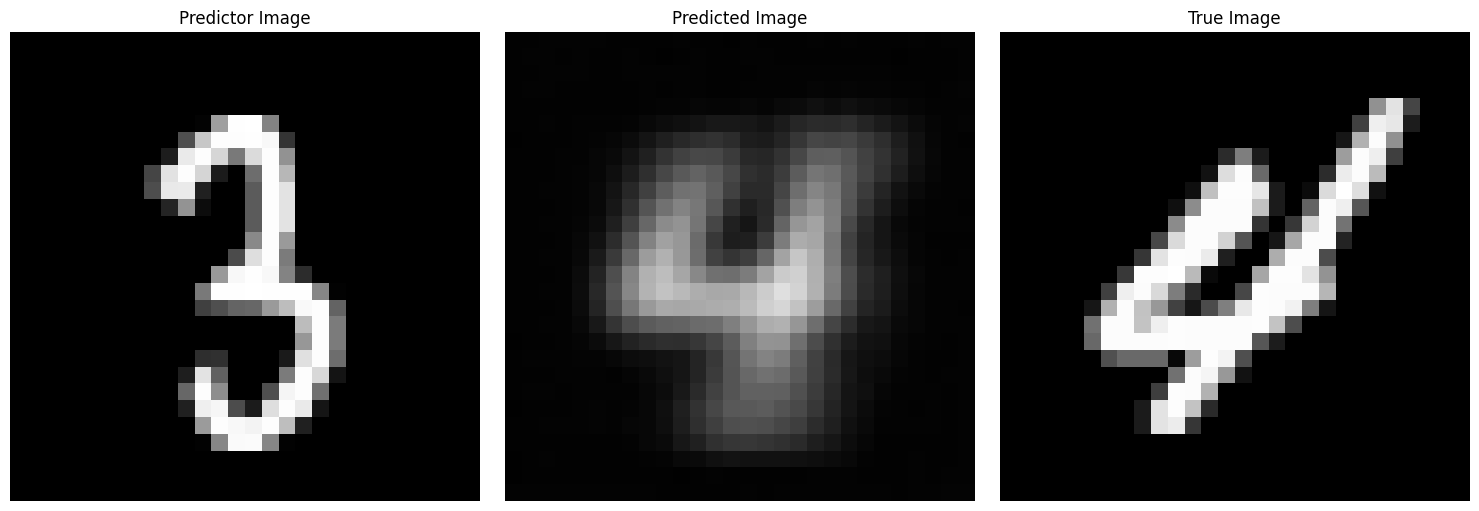

In [5]:
#load from a checkpoint
epoch = 4
model_name = "ConvAutoEncoder"
model = ConvAutoEncoder(
    n_input_channels = n_input_channels,
    n_output_channels = n_output_channels,
    n_conv_filters = n_conv_filters,
    n_layers_per_block = n_layers_per_block
)
checkpoint = torch.load(os.path.join(package_root, "models", "MNIST_num2num", "model_checkpoints", model_name,f"epoch{epoch}.pth"), weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

#make prediction plot as before, but with trained model
device = "cuda"
model.to(device)
rand_test_idx = np.random.randint(len(test_ds))
i = rand_test_idx
X, y = test_ds[i]
X = X[np.newaxis,:,:,:]
X_gpu = torch.from_numpy(X).to(device)
with torch.no_grad():
    pred = model(X_gpu)
    pred = pred.cpu().numpy()
plot_num2num_prediction(X, y, pred)


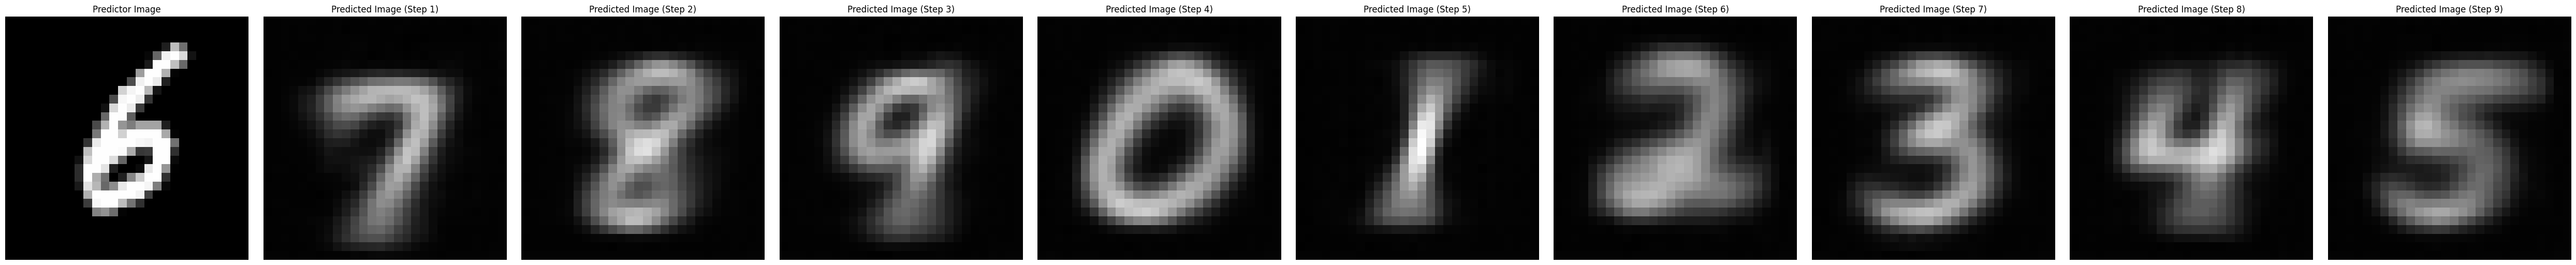

In [6]:
def plot_autoregressive_sequence(X, model, n_steps=3):
    """
    Plots the progression from the original predictor image through n autoregressive steps.
    :param X: numpy array - Original predictor image
    :param model: torch.nn.Module - Trained model for predictions
    :param n_steps: int - Number of autoregressive steps to take
    """
    device = next(model.parameters()).device  # Ensure using the correct device
    X_gpu = torch.from_numpy(X).unsqueeze(0).to(device) #makes sure there's a batch dimension

    predictions = [X]  # Start with the original predictor
    current_input = X_gpu

    with torch.no_grad():
        for _ in range(n_steps):
            pred = model(current_input)  # Predict next step
            pred_np = pred.cpu().numpy()  # Convert to numpy
            predictions.append(pred_np)  # Store result
            current_input = torch.from_numpy(pred_np).to(device)  # Use prediction as new input
            if current_input.dim() == 3:  
                current_input = current_input.unsqueeze(0)

    # Create dynamic plotting layout
    n_cols = n_steps + 1  # Predictor + n steps + True image
    fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, 5))

    # Plot predictor image
    axes[0].imshow(X.squeeze(), cmap="gray", vmin=0., vmax=1.)
    axes[0].set_title("Predictor Image")
    axes[0].axis("off")

    # Plot each autoregressive step
    for i in range(1, n_steps + 1):
        axes[i].imshow(predictions[i].squeeze(), cmap="gray", vmin=0., vmax=1.)
        axes[i].set_title(f"Predicted Image (Step {i})")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Select a random test sample
rand_test_idx = np.random.randint(len(test_ds))
X, y = test_ds[rand_test_idx]

# Call function with n autoregressive steps
plot_autoregressive_sequence(X, model, n_steps=9)